## Introduction

In this notebook, I've tried experimenting with the observations.  
Instead of following the normal workflow of EDA, outliers detection-removal, then move towards model building,  
- first I've built the model and check the metrics without any preprocessing.
- then, scaling, handling outliers etc. has been done to see how each of these steps improve the model's performance.

#### Steps:

1. Import necessary libraries.
2. Create a sample DataFrame.
3. Define features (X) and target (y).
4. Split the data into train and test sets.
5. Standardize the features.
6. Initialize and train the respective model.
7. Make predictions on the test set.
8. Evaluate the model using Mean Squared Error (MSE) and R² Score.
9. Plot the actual vs. predicted values.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [52]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
##Model accuracy
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score

In [66]:
from sklearn.model_selection import GridSearchCV

In [51]:
from sklearn.linear_model import Lasso

In [5]:
salary = pd.read_csv('https://github.com/ybifoundation/Dataset/raw/main/Salary%20Data.csv')

In [6]:
salary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Experience Years  40 non-null     float64
 1   Salary            40 non-null     int64  
dtypes: float64(1), int64(1)
memory usage: 772.0 bytes


In [7]:
salary.head(3)

,Experience Years,Salary
0,1.1,39343
1,1.2,42774
2,1.3,46205


In [8]:
salary.describe()

,Experience Years,Salary
count,40.000000,40.000000
mean,5.152500,74743.625000
std,2.663715,25947.122885
min,1.100000,37731.000000
25%,3.200000,56878.250000
50%,4.600000,64472.500000
75%,6.875000,95023.250000
max,10.500000,122391.000000


In [9]:
#make a copy of dataframe
salary2 = salary.copy()

In [10]:
salary2.rename(columns = {'Experience Years': 'years', 'Salary':'income'}, inplace = True)

In [11]:
salary2.columns

Index(['years', 'income'], dtype='object')

### Without Scaling

In [12]:
X = salary2.years
Y = salary2.income

In [13]:

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.7, random_state = 101)

In [14]:
#check shape of the subsets
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((28,), (12,), (28,), (12,))

In [15]:
#what's the type of this object
type(X_train)

pandas.core.series.Series

In [16]:
#convert all to numpy array
X_train = X_train.values.reshape(-1,1)
X_test = X_test.values.reshape(-1,1)
Y_test = Y_test.values.reshape(-1,1)
Y_train = Y_train.values.reshape(-1,1)

In [17]:
#model
model = LinearRegression()

In [18]:
#reshape the train dataset to be a dataframe, not series
#x_train = X_train.values.reshape(-1,1)
#X_train.head(3)

In [19]:
#train the model
model.fit(X_train, Y_train)

LinearRegression()

In [20]:
#see all attributes, functions present for model object
#dir(model)
#check intercept and x-coefficient
print("Intercept: {0}".format(model.intercept_))
print("Coefficient: {0}".format(model.coef_))
print("Linear Regression Eq: y = ({0})X + {1}".format(round(model.coef_.item(),2), round(model.intercept_.item(),2)))

Intercept: [26193.35145929]
Coefficient: [[9254.54992096]]
Linear Regression Eq: y = (9254.55)X + 26193.35


In [21]:
#perform prediction
y_pred = model.predict(X_test)

In [22]:
#glimpse
y_pred[0:3]

array([[ 65987.91611942],
       [ 63211.55114313],
       [114111.57570841]])

In [24]:
mae = mean_absolute_error(y_pred, Y_test)
mae_percent = mean_absolute_percentage_error(y_pred, Y_test)
mse = mean_squared_error(y_pred, Y_test)

In [25]:
#view all errors
print("Mean Absolute Error: {0}".format(mae))
print("Mean Absolute Percentage Error: {0}".format(mae_percent))
print("Mean Squared Error: {0}".format(mse))

Mean Absolute Error: 5943.550801606815
Mean Absolute Percentage Error: 0.08108403900679219
Mean Squared Error: 46267147.44799886


- On average, the model's predicted salary deviates from the original salary by 5943 rupees. (MAE)
- On average, model's predictions are off by about 8.11% relative to original salary values (MAPE)
- Mean Sqaured error is very large implying model's sensitivity to some large deviations in predictions.

___Since MSE is relatively very high as compared to MAE, it suggests presence of large outliers in the dataset which will be investigated further.___

#### Checking for outliers using residual plot

In [26]:
#run model on the training set to find the outcomes
training_pred = model.predict(X_train)

In [27]:
#convert to 1-D array
#ytrain = np.array([Y_train])
#train_pred = np.array([training_pred])
#find residual
residuals = Y_train - training_pred

In [28]:
# Flatten the residuals if it's 2D
if residuals.ndim == 2:
    residuals = residuals.ravel()

#### Residual Plot

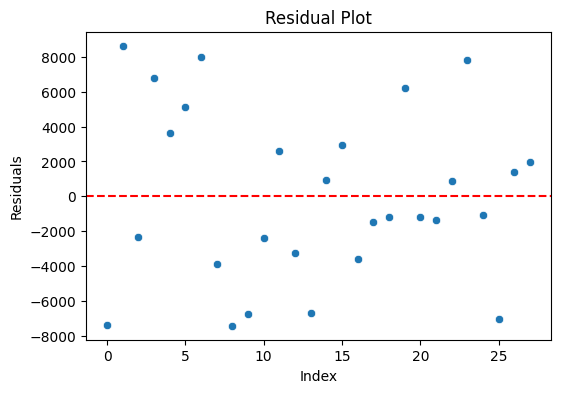

In [29]:
#plot the residual
plt.figure(figsize=(6, 4))
sns.scatterplot(x=range(len(residuals)), y=residuals)
plt.axhline(y=0, color = 'red', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Index')
plt.ylabel('Residuals')
plt.show()

- Points do not follow any pattern and are randomly scattered. Model seems to capture relationship- OK.
- Some points way too far from the baseline. But as checked from graphs below, no outliers present. So, accuracy can be improved.
- Let's see how scaling affects the model coefficients and output.

#### Visualize fit of the model

In [30]:
#convert xtest and ypred etc. to 1-d array for plotting
xtest_1d = X_test.ravel()
ypred_1d = y_pred.ravel()
ytest_1d = Y_test.ravel()

In [31]:
xtrain_1d = X_train.ravel()
ytrain_1d = Y_train.ravel()
training_pred_1d = training_pred.ravel()

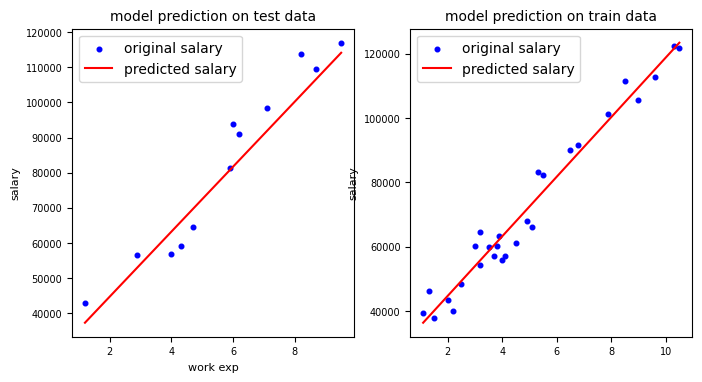

In [32]:
#visualize the result of model on training and test set
fig, ax = plt.subplots(1, 2, figsize = (8,4))

#subplot 1
ax[0].scatter(X_test, Y_test, color = 'blue', label = 'original salary', s=11)
sns.lineplot(x=xtest_1d, y=ypred_1d, ax=ax[0], color='red', label='predicted salary')
ax[0].set_title('model prediction on test data', fontsize = 10)
ax[0].tick_params(axis = 'both', labelsize = 7)
ax[0].set_xlabel('work exp', fontsize = 8)
ax[0].set_ylabel('salary', fontsize=8)

#subplot 2
ax[1].scatter(X_train, Y_train, color = 'blue', label = 'original salary', s=11)
sns.lineplot(x=xtrain_1d, y=training_pred_1d, ax=ax[1], color='red', label='predicted salary')
ax[1].set_title('model prediction on train data', fontsize = 10)
ax[1].tick_params(axis = 'both', labelsize = 7)
#ax[1].set_xlabel('work exp', fontsize = 8)
ax[1].set_ylabel('salary', fontsize=8)

plt.show()

From everything I saw above:  
1. Mean absolute percentage error was only 8.11% but mean squared error was very high.
2. From these graphs above, the line seesm to fit the model good!
3. The scale of the features might be impacting the large error values.
4. Now, i'll scale the data and check the metrics again..

## Model performance after scaling

#### 1. Density Distribution

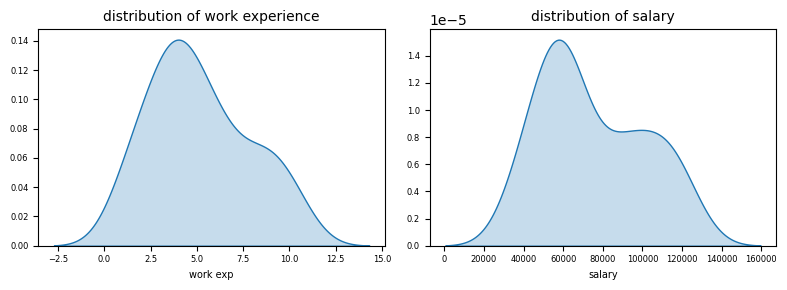

In [33]:
#check distribution of work experience and salary
fig, ax = plt.subplots(1, 2, figsize = (8,3))

sns.kdeplot(salary2.years, ax=ax[0], fill=True)
ax[0].set_title('distribution of work experience', fontsize = 10)
ax[0].set_xlabel('work exp', fontsize = 7)
ax[0].set_ylabel('')
ax[0].tick_params(axis = 'x', labelsize = 6)
ax[0].tick_params(axis = 'y', labelsize = 6)

sns.kdeplot(salary2.income, ax = ax[1], fill = True)
ax[1].set_title('distribution of salary', fontsize = 10)
ax[1].set_xlabel('salary', fontsize = 7)
ax[1].set_ylabel('')
ax[1].tick_params(axis = 'x', labelsize = 6)
ax[1].tick_params(axis = 'y', labelsize = 6)

plt.tight_layout()
plt.show()

#### 2. Scatter Plot

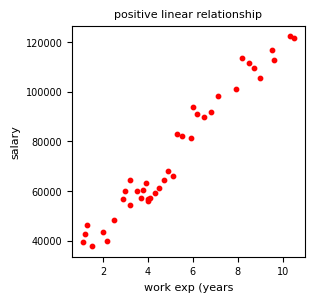

In [34]:
fig, ax = plt.subplots(1, 1, figsize = (3,3))
plt.scatter(salary2.years, salary2.income, c='red', s=10)
plt.title('positive linear relationship', fontsize = 8)
plt.tick_params(axis = 'both', labelsize = 7)
plt.xlabel('work exp (years', fontsize = 8)
plt.ylabel('salary', fontsize = 8)
plt.show()

#### 3. Box Plot

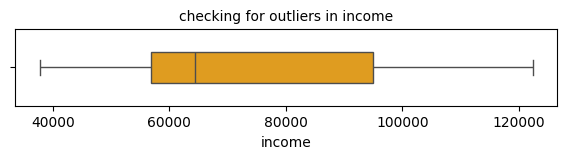

In [35]:
plt.figure(figsize = (7,1))

sns.boxplot(salary2.income, orient = 'h', width = 0.4, color='orange')
plt.title('checking for outliers in income', fontsize = 10)
plt.show()

#### Train data with standardized feature

In [36]:
#make a copy of dataframe
salary3 = salary2.copy()

In [37]:
x = salary3[['years']]
y = salary3['income']

In [38]:
#split the dataset
xtrain, xtest, ytrain, ytest = train_test_split(x, y, train_size = 0.7, random_state = 101)

In [39]:
#create an instance
std_scaler = StandardScaler()

In [40]:
#scale
xtrain_scaled = std_scaler.fit_transform(xtrain)
xtest_scaled = std_scaler.fit_transform(xtest)

In [41]:
#shape of split data-subsets
xtrain_scaled.ndim

2

In [42]:
print("type of the xtrain: ", type(xtrain))
print("type of the test object: ", type(ytest))

type of the xtrain:  <class 'pandas.core.frame.DataFrame'>
type of the test object:  <class 'pandas.core.series.Series'>


In [43]:
#create model
model2 = LinearRegression()
#train the dataset
model2.fit(xtrain_scaled, ytrain)

LinearRegression()

In [44]:
print("yintercept: {0}".format(round(model2.intercept_.item(),3)))
print("slope: {0}".format(round(model2.coef_.item(),3)))

yintercept: 71606.75
slope: 25049.551


In [45]:
#prediction
ytest_pred = model2.predict(xtest_scaled)

In [46]:
#metrics
model2_mse = mean_squared_error(ytest_pred, ytest)
model2_mae = mean_absolute_error(ytest_pred, ytest)
model2_mape = mean_absolute_percentage_error(ytest_pred, ytest)

In [53]:
model2_r2 = r2_score(ytest_pred, ytest)

In [54]:
#view all errors
print("Mean Absolute Error: {0}".format(model2_mae))
print("Mean Absolute Percentage Error: {0}".format(model2_mape))
print("Mean Squared Error: {0}".format(model2_mse))
print("R-squared: {0}".format(model2_r2))

Mean Absolute Error: 10456.25000000001
Mean Absolute Percentage Error: 0.19549686730490168
Mean Squared Error: 145481771.73431057
R-squared: 0.7681491560495676


In [48]:
## Model performance on training data
ytrain_pred = model2.predict(xtrain_scaled)
#calcualate residuals
residuals = ytrain - ytrain_pred

In [49]:
#convert to 1d array for plotting
xtest_scaled_1d = xtest_scaled.ravel()
#ytest_pred_1d = ytest_pred.ravel()
xtrain_scaled_1d = xtrain_scaled.ravel()
#ytrain_pred_1d = ytrain_pred.ravel()

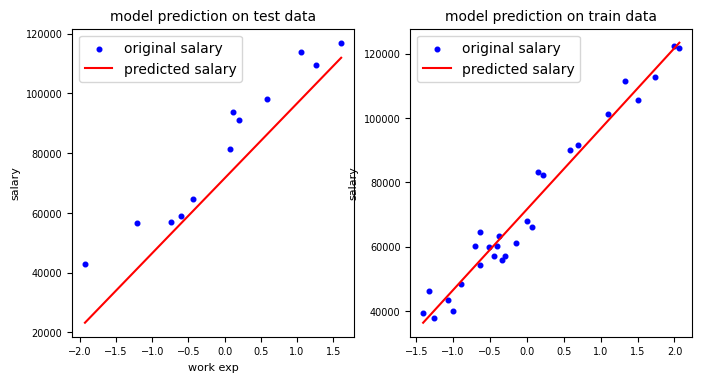

In [50]:
#visualize the result of model on training and test set
fig, ax = plt.subplots(1, 2, figsize = (8,4))

#subplot 1
ax[0].scatter(xtest_scaled, ytest, color = 'blue', label = 'original salary', s=11)
sns.lineplot(x=xtest_scaled_1d, y=ytest_pred, ax=ax[0], color='red', label='predicted salary')
ax[0].set_title('model prediction on test data', fontsize = 10)
ax[0].tick_params(axis = 'both', labelsize = 7)
ax[0].set_xlabel('work exp', fontsize = 8)
ax[0].set_ylabel('salary', fontsize=8)

#subplot 2
ax[1].scatter(xtrain_scaled, ytrain, color = 'blue', label = 'original salary', s=11)
sns.lineplot(x=xtrain_scaled_1d, y=ytrain_pred, ax=ax[1], color='red', label='predicted salary')
ax[1].set_title('model prediction on train data', fontsize = 10)
ax[1].tick_params(axis = 'both', labelsize = 7)
#ax[1].set_xlabel('work exp', fontsize = 8)
ax[1].set_ylabel('salary', fontsize=8)

plt.show()

After standardizing the work-experience feature, the output graph shows that the model didn't fit the data properly.  
The line was a better fit with un-standardized feature and error-metrics were also lower.  
The mean absolute error is `~$5400` with first model and almost double `~$10,400` with second model.

___Seems like due to small dataset (40 observations only), model is overfitting. In the section below, ive tried out lasso and ridge regression to see if the metrics improve or not.___

### Mitigate Overfitting problem

### 1. Lasso Regression

In [64]:
#initialize lasso model
lasso = Lasso(alpha = 100)
#fit the model
lasso.fit(xtrain_scaled, ytrain)
#make predictions
lasso_test_pred = lasso.predict(xtest_scaled)
#evaluation metrics
lasso_mse = mean_squared_error(ytest, lasso_test_pred)
lasso_r2 = r2_score(ytest, lasso_test_pred)
lasso_mae = mean_absolute_error(ytest, lasso_test_pred)

In [65]:
#print all metrics
print(f'Lasso Mean Squared Error: {lasso_mse}')
print(f'Lasso Mean Absolute Error: {lasso_mae}')
print(f'Lasso R^2 Score: {lasso_r2}')

Lasso Mean Squared Error: 145209741.04726896
Lasso Mean Absolute Error: 10456.250000000005
Lasso R^2 Score: 0.75511915044367


In [63]:
# # Plotting the results
# import matplotlib.pyplot as plt
# plt.figure(figsize=(6, 4))
# plt.scatter(X_test, y_test, color='blue', label='Actual')
# plt.plot(X_test, y_pred, color='red', linewidth=2, label='Predicted')
# plt.xlabel('Work Experience')
# plt.ylabel('Salary')
# plt.title('Lasso Regression')
# plt.legend()
# plt.show()

In [ ]:
#FINDING BEST ALPHA THROUGH CROSS-VALIDATION
# Define features and target
X = df[['work_experience']]
y = df['salary']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Use LassoCV to find the best alpha
lasso_cv = LassoCV(alphas=None, cv=10, random_state=42)  # alphas=None lets LassoCV choose a range of alphas automatically
lasso_cv.fit(X_train_scaled, y_train)

# Best alpha found by cross-validation
best_alpha = lasso_cv.alpha_
print(f'Best alpha: {best_alpha}')

# Train Lasso model with the best alpha
lasso_best = Lasso(alpha=best_alpha)
lasso_best.fit(X_train_scaled, y_train)

# Make predictions
y_pred = lasso_best.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

# Plotting the results
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
plt.scatter(X_test, y_test, color='blue', label='Actual')
plt.plot(X_test, y_pred, color='red', linewidth=2, label='Predicted')
plt.xlabel('Work Experience')
plt.ylabel('Salary')
plt.title('Lasso Regression with Optimal Alpha')
plt.legend()
plt.show()